In [1]:
import numpy as np
from scipy.stats import dirichlet
import copy
from scipy.special import kl_div
import torch
from scipy.stats import entropy
import scipy.stats as st
import seaborn as sns

In [2]:
def U(xs, alphas):
    fun_U = 0
    for i in range(len(xs)):
        fun_U += (alphas[i] - 1) * np.log(xs[i])
    return -fun_U

# constraint = \sum_i (-x_i 1_{x_i<0}) + (1 - \sum_i x_i) ^ 2
def U_constraint(xs, delta):
    constraints = 0
    sums = np.sum(xs)
    for x in xs:
        if x < 0:
            constraints += np.abs(x)
    constraints += (1-sums) ** 2
    return constraints / delta

def U_gradient(xs, alphas, delta):
    grad = np.zeros(len(xs))
#     calculate constraints
    constraints = U_constraint(xs,delta)
    sums = np.sum(xs)
    for i in range(len(xs)):
        if xs[i]<=0:
            grad[i] -= 1/delta
        else:
            grad[i] += - (alphas[i]-1) * 1/xs[i]
        grad[i] += 2 * (sums - 1) / delta
    return grad

def F_gradient(xs, alphas):
    grad = np.zeros(len(xs))
    for i in range(len(xs)):
        grad[i] += - (alphas[i]-1) * 1/xs[i]
    return grad

# utility functions to calculate covariance between two gaussian random variable
def phi0(t, gamma):
    return np.exp(-t * gamma)

def phi1(t, gamma):
    return - 1/gamma * np.exp(-t * gamma) + 1 / gamma

def phi2(t, gamma):
#     tmp = 1/gamma ** 2
    tmp = (1/gamma ** 2) * (np.exp(-gamma*t)-1)
    tmp = tmp + t/gamma
    return tmp

# coveriance between two related randomness
def covariance(t, gamma):
    e2gt = np.exp(-2*gamma*t)
    egt = np.exp(-gamma*t)
    a11 = - (1/(2*gamma)) * e2gt + 1/(2*gamma)
    a12 = e2gt / (2*gamma*gamma) - egt/(gamma**2) - 1/(2*(gamma**2)) + 1/(gamma ** 2)
    a22 = -e2gt/(2*(gamma ** 3)) + 2*egt / (gamma**3) + 1/(2 * (gamma ** 3)) - 2/(gamma ** 3) + t/(gamma ** 2)
    tmp = np.array([[a11, a12], [a12,a22]])
    return tmp

In [51]:
from scipy.stats import wasserstein_distance

dim = 3
alphas = [1,2,2]
# number of random variables
N = 1000
x0=[]

for i in range(N):
#     initialized point
    x0.append([0.2, 0.4, 0.4])
    
lr = 0.0012
max_iter = 2000
delta = 0.01

diri = dirichlet.rvs(alphas, size = N)

dist = []
kl = []
x0 = np.array(x0)
v = np.zeros(shape = (N, dim))
gamma = 0.6

for ite in range(max_iter):
#     learning rate decaying
    if ite % 200 == 0 and ite != 0:
        lr = lr * 0.9
    for i in range(len(x0)):
        
        cov = covariance(lr, gamma)
        rand = np.random.multivariate_normal([0]*2, cov, size = dim)
        rand1 = rand[:,0]
        rand2 = rand[:,1]
        grad = U_gradient(x0[i], alphas, delta)
        
        v_new = phi0(lr, gamma) * v[i] - phi1(lr,gamma)*grad + np.sqrt(2*gamma) * rand1
        x0[i] = x0[i] + phi1(lr,gamma)*v[i] - phi2(lr,gamma)*grad + np.sqrt(2*gamma) * rand2
        v[i] = v_new
    
    tmp_dist = []
    tmp_kl = []
#     calcualte the 2 wasserstein distance for each dimension
    for i in range(dim):
        tmp_dist.append(wasserstein_distance(diri[:,i], x0[:,i]))
        tmp_kl.append(kl_div(diri[:,i], x0[:,i]))
    dist.append(tmp_dist)
    kl.append(tmp_kl)


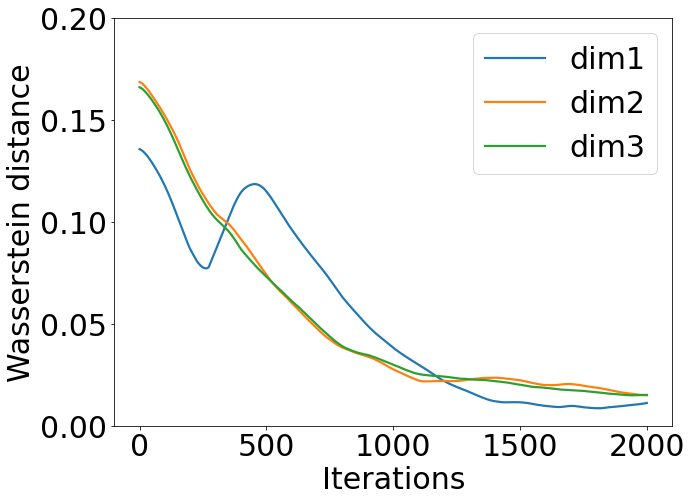

In [53]:
# 2 wasserstein distance plot
dist = np.array(dist)
kl = np.array(kl)
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,7.5))
plt.plot(dist[:,0],linewidth=2.2)
plt.plot(dist[:,1],linewidth=2.2)
plt.plot(dist[:,2],linewidth=2.2)
plt.xlabel('Iterations',fontsize=30)
plt.ylabel('Wasserstein distance',fontsize=30)
plt.tick_params(labelsize=30)
plt.legend(['dim1','dim2','dim3'],loc='best',fontsize=30)
plt.ylim([0, 0.2])
plt.show()

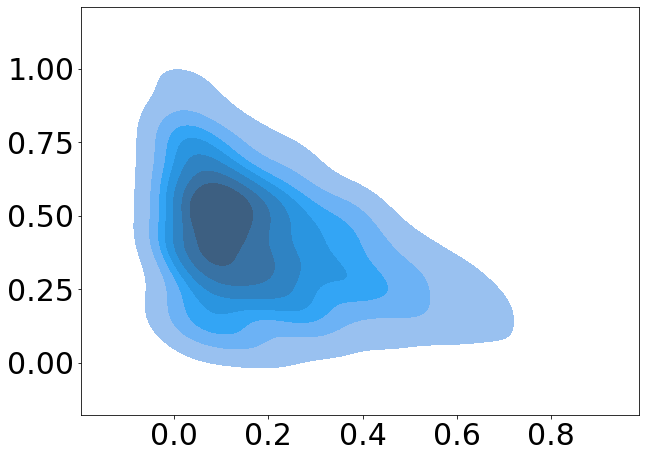

In [54]:
# density plot of PSGMC algorithm
fig=plt.figure(figsize=(10,7.5))
sns.kdeplot(x = x0[:,0], y = x0[:,1], fill = True, levels = 8)
plt.tick_params(labelsize=30)
plt.show()